In [279]:
import terra_to_data as ttd
import materials_propellant as mp
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [280]:
ttd.open_terra_df('Результаты расчёта в тере.xlsx')

In [281]:
# Теплофизические параметры ПС
# первая T, вторая p!!!!!
km = ttd.to_data('kg')
Rm = ttd.to_data('Rg')
mu_m = ttd.to_data('Mu')
lambda_t_m = ttd.to_data('Lt')
cpm = ttd.to_data('Cpg')
Prm = ttd.to_data('Pr')

k = lambda p,T: km(T,p / 1e6)[0]
R = lambda p,T: Rm(T,p / 1e6)[0]
mu = lambda p,T: mu_m(T,p / 1e6)[0]
lambda_t = lambda p,T: lambda_t_m(T,p / 1e6)[0]
cp = lambda p,T: cpm(T,p / 1e6)[0]*1e3
Pr = lambda p,T: Prm(T,p / 1e6)[0]

In [282]:
M_mum = ttd.to_data('MMg') #молярная масса газовой фазы
Ch2o = ttd.to_data('H2O')
Cco2m = ttd.to_data('CO2')
Cch4m = ttd.to_data('CH4')

In [283]:
#вспомогательные гд функции
tau = lambda lmbd, k: 1 - (k - 1)/(k + 1)*lmbd**2
pi = lambda lmbd, k: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
eps = lambda lmbd, k: pi(lmbd,k) / tau(lmbd,k)
q = lambda lmbd, k:  ((k + 1) / 2)**(1 / (k - 1)) * lmbd * eps(lmbd, k)
nu = lambda lmbd, k: 1 / q(lmbd,k)
f = lambda lmbd, k: (lmbd**2 + 1) * (1 - (k - 1) / (k + 1) * lmbd**2) ** (1 / (k - 1))

A = lambda k: np.sqrt(k * ((2 / (k + 1))**((k + 1) / (k - 1))))

In [284]:
# свойства топлива
propellant_name = '11% ПБГГ, 69,5% ПХА, 19% Al, 0,5% Fe2O3'
propellant = mp.get_mixed_propellant(propellant_name)
p0 = 15e6
T0 = propellant['T_0']
rho_t = propellant['rho_т']
nu = propellant['nu']
Fz = lambda T: np.exp(propellant['D_t'] * (T - 291.15))
z = 0.359
rho_kf = 2200
cs = 1378
Q_zh = k(p0,T0) / (k(p0,T0) - 1) * R(p0,T0) * T0
print(f'Q_zh = {Q_zh/1e6:.3f}')

# первое приближение коэф. неравновесности
Kv = 0.95
Kt = 1.05

# дополнительные параметры
lambda_a2 = 2.380
nu_a2 = 14
p_a = 95461

D = 0.17
#L2 = 0.923
F_oxl = 0.05
print(f'F_oxl = {F_oxl:.5f}')
sigma_t = 300
nu_t = 0.7
omega = 24
t_r = 2.8

delta_st = 2e-3
delta_tzp = 4e-3

I_ud = 2966
I_sum = 72997

Q_zh = 7.222
F_oxl = 0.05000


In [285]:
# коэф. учитывающий к-фазу
chi1 = cs / cp(p0, T0) * Kt
chi2 = (k(p0, T0) - 1) / (k(p0, T0) + 1) * Kv**2 * lambda_a2**2
chi_t = np.sqrt(1 / (1 - z) * (1 + z / (1 - z) * (chi1 + chi2)))
print(f'chi_t = {chi_t:.3f}')


chi_t = 1.638


In [286]:
def find_nu_a():
    find_lambda = lambda lmbd: 1 / nu_a2 - q(lmbd,k(p0,T0))
    lambda_a0 = fsolve(find_lambda,1.3)[0]
    T_a0 = T0 * tau(lambda_a0,k(p0,T0))
    eps_lambda, eps_T = 100, 100
    while eps_lambda > 0.001 and eps_T > 1:
        T_a1 = T0 * tau(lambda_a0,k(p_a,T_a0))
        find_lambda1 = lambda lmbd: p_a / p0 - pi(lmbd,k(p_a,T_a0))
        lambda_a1 = fsolve(find_lambda1,1.3)[0]
        eps_lambda = abs(lambda_a1 - lambda_a0)
        eps_T = abs(T_a1 - T_a0)
        lambda_a0 = lambda_a1
        T_a0 = T_a1

    find_nu = lambda nu: 1 / nu - q(lambda_a1,k(p_a,T_a0))
    nu_ar = fsolve(find_nu,nu_a2)[0]

    return nu_ar, lambda_a1, T_a0

nu_a, lambda_a, T_a = find_nu_a()

print(f'nu_a = {nu_a:.3f}\n',
      f'lambda_a = {lambda_a:.3f}\n',
      f'T_a = {T_a:.3f}')

nu_a = 12.923
 lambda_a = 2.270
 T_a = 1063.070


In [287]:
G_t = omega / t_r
chi_tepl1 = sigma_t * nu_t * F_oxl * p0 / (Q_zh * R(p0, T0) * G_t)
chi_tepl2 = k(p0, T0) / (k(p0, T0) - 1) * p0 / (rho_t * Q_zh)
chi_tepl = 1 - chi_tepl1 - chi_tepl2
print(chi_tepl)
G_t

0.9880491035642721


8.571428571428571

In [288]:
D_vx = D - 2 * (delta_st + delta_tzp)

nu_c = 0.95
F_kr1 = np.sqrt((k(p0, T0) - 1) / k(p0, T0) * chi_tepl * Q_zh)
F_kr2 = G_t / (nu_c * A(k(p0, T0)) * p0)
F_kr = F_kr1 * F_kr2 / chi_t

D_kr = round(np.sqrt(4 * F_kr / np.pi), 4)
D_a = round(D_kr * np.sqrt(nu_a), 3)

print(f'D_vx = {D_vx:.3f}\n',
      f'F_kr = {F_kr:.5f}\n',
      f'D_kr = {D_kr:.4f}\n',
      f'D_a = {D_a:.3f}\n')


D_vx = 0.158
 F_kr = 0.00067
 D_kr = 0.0291
 D_a = 0.105



In [289]:
# Радиусы скругления
R_ks = D_vx / 2
print(f'0..{R_ks*1e3}')
R_scr = 100e-3
R_kr = D_kr / 2
print(f'R_kr = {R_kr}')
print(f'r_b = R_kr = {R_kr*1e3}')
print(f'r_скр = {np.round(0.53*R_kr*1e3)}')
print(f'R_a/R_kr = {D_a / D_kr}')
La = 6*R_kr
print(f'lambda5 = {La:.3f}')
# beta_вх = 0.4
# L = 1567

0..79.0
R_kr = 0.01455
r_b = R_kr = 14.55
r_скр = 8.0
R_a/R_kr = 3.608247422680412
lambda5 = 0.087


In [290]:
ttd.open_soplo('Профиль.xlsx')
x_soplo, R_soplo, Rss = ttd.soplo()
Fss = ttd.F_soplo()
for x,R_val in zip(x_soplo,R_soplo):
    if abs(R_val - R_kr) < 1e-7:
        x_kr = x
        break

x_kr

0.05914

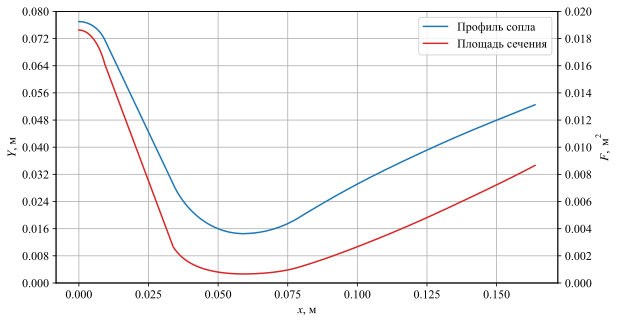

In [291]:
fig = plt.figure(figsize=(9, 5))
host = fig.add_subplot(111)
par1 = host.twinx()

Ylim = (0, 0.08, 11)
Flim = (0, 0.02, 11)
host.set_ylim(*Ylim)
par1.set_ylim(*Flim)

n_g = 11
host.yaxis.set_ticks(np.linspace(*Ylim, n_g))
par1.yaxis.set_ticks(np.linspace(*Flim, n_g))

host.set_xlabel("$\mathit{x}$, м")
host.set_ylabel("$\mathit{Y}$, м")
par1.set_ylabel("$\mathit{F},$ $м^2$")

color1 = 'darkorange'
color2 = 'darkred'


p11, = host.plot(x_soplo,R_soplo, label = 'Профиль сопла')
p21, = par1.plot(x_soplo,Fss(x_soplo), c = 'tab:red', label = 'Площадь сечения')

lns = [p11, p21]

host.legend(handles=lns, loc='best')

host.grid()

In [292]:
# Расчет параметров по тракту сопла
Pr = lambda p, T: cp(p,T) * mu(p,T) / lambda_t(p,T)

M = lambda p, T, lmbd: np.sqrt((2 / (k(p,T) + 1) * lmbd ** 2) / 
                               (1 - (k(p,T) - 1) / (k(p,T) + 1) * lmbd ** 2))
T_r = lambda p, T, lmbd: T * (1 + (k(p,T) - 1) / 2 *
                         (Pr(p,T)**(1/3) * M(p,T,lmbd)**2))
H_r = lambda p, T, lmbd: cp(p,T_r(p,T,lmbd)) * T_r(p,T,lmbd)
T_w = lambda p, T, lmbd: 0.8 * T_r(p,T,lmbd)
H_w = lambda p,T,lmbd: cp(p,T_w(p,T,lmbd)) * T_w(p,T,lmbd)
rho_w = lambda p,T,lmbd: p / (R(p,T_w(p,T,lmbd)) * T_w(p,T,lmbd))

V = lambda p,T,lmbd: M(p,T,lmbd) * np.sqrt(k(p,T) * R(p,T) * T)
Re_w = lambda p,T,lmbd,r: V(p,T,lmbd) * rho_w(p,T,lmbd) * r / mu(p,T)

def St_zv(p,T,lmbd,r):
    St1 = 0.0326 * Re_w(p,T,lmbd,r) ** (-0.2) * Pr(p,T) ** (-0.6)
    St2 = (H_w(p,T,lmbd) / H_r(p,T,lmbd)) ** 0.39
    St3 = (1 + (k(p,T) - 1) / 2 * Pr(p,T) ** (1/3) * M(p,T,lmbd) ** 2) ** 0.11
    return St1 * St2 * St3

k_sh = 1 + 0.15 * 0.2 ** 0.29
k_p = lambda p,T,lmbd,r: 1 + 0.0246 * Re_w(p,T,lmbd,r) ** (-0.3) * (z / (1 - z)) ** 2.45

St = lambda p,T,lmbd,r: St_zv(p,T,lmbd,r) * k_sh * k_p(p,T,lmbd,r)

alpha_t = lambda p,T,lmbd,r: rho_w(p,T,lmbd) * V(p,T,lmbd) * St(p,T,lmbd,r) * cp(p,T)

q_k = lambda p,T,lmbd,r: alpha_t(p,T,lmbd,r) * (T_r(p,T,lmbd) - T_w(p,T,lmbd))

In [293]:
def get_par_x():
    lambdas = []
    ps = [p0]
    Ts = [T0]
    Ms = []
    Vs = []
    rho_ws = []
    T_rs = []
    T_ws = []
    Res = []
    St_zvs = []
    Sts = []
    alphas = []
    qs = []
    C_h2os = []
    C_ch4s = []
    C_co2s = []
    M_mus = []
    xs = np.linspace(0,x_soplo[-1],150)

    for x in xs:
        find_lambda = lambda lmbd: q(lmbd,k(ps[-1],Ts[-1])) - F_kr / Fss(x)
        lambda_inf = np.sqrt((k(ps[-1],Ts[-1]) + 1) / (k(ps[-1],Ts[-1]) - 1))
        lambdai = fsolve(find_lambda,0.1)[0] if x < x_kr else fsolve(find_lambda,1.8)[0]
        lambdas.append(lambdai)

        ps.append(p0 * pi(lambdai,k(ps[-1],Ts[-1])))
        Ts.append(T0 * tau(lambdai,k(ps[-1],Ts[-1])))
        Ms.append(M(ps[-1],Ts[-1],lambdai))
        Vs.append(V(ps[-1],Ts[-1],lambdai))
        Rsi = Rss(x)
        rho_ws.append(rho_w(ps[-1],Ts[-1],lambdai))
        T_rs.append(T_r(ps[-1],Ts[-1],lambdai))
        T_ws.append(T_w(ps[-1],Ts[-1],lambdai))
        Res.append(Re_w(ps[-1],Ts[-1],lambdai,Rsi))
        St_zvs.append(St_zv(ps[-1],Ts[-1],lambdai,Rsi))
        Sts.append(St(ps[-1],Ts[-1],lambdai,Rsi))
        alphas.append(alpha_t(ps[-1],Ts[-1],lambdai,Rsi))
        qs.append(q_k(ps[-1],Ts[-1],lambdai,Rsi))

        C_h2os.append(Ch2o(Ts[-1],ps[-1]/1e6)[0])
        C_co2s.append(Cco2m(Ts[-1],ps[-1]/1e6)[0])
        C_ch4s.append(Cch4m(Ts[-1],ps[-1]/1e6)[0])
        M_mus.append(M_mum(Ts[-1],ps[-1]/1e6)[0])

    result = {
        'lambda': np.array(lambdas),
        'p': np.array(ps[1:]),
        'T': np.array(Ts[1:]),
        'M': np.array(Ms),
        'V': np.array(Vs),
        'rho_w': np.array(rho_ws),
        'T_r': np.array(T_rs),
        'T_w': np.array(T_ws),
        'Re': np.array(Res),
        'St_zv': np.array(St_zvs),
        'St': np.array(Sts),
        'alpha': np.array(alphas),
        'q': np.array(qs),
        'x': np.array(xs),
        'C_h2o': np.array(C_h2os),
        'C_co2': np.array(C_co2s),
        'C_ch4': np.array(C_ch4s),
        'M_mu': np.array(M_mus)
    }

    return result

In [294]:
res = get_par_x()

C:\Users\HP\miniconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


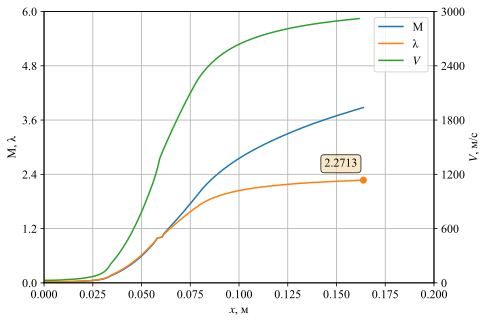

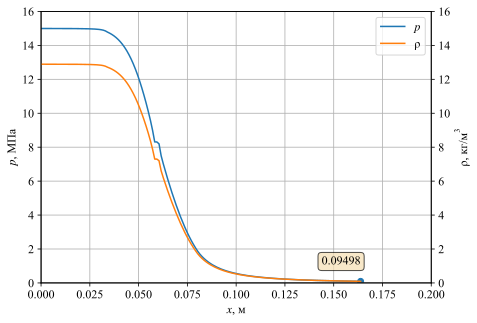

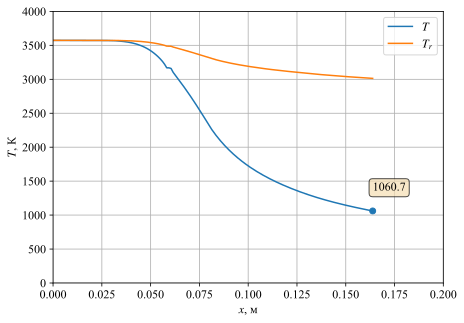

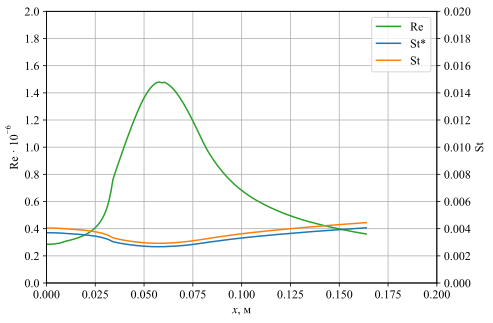

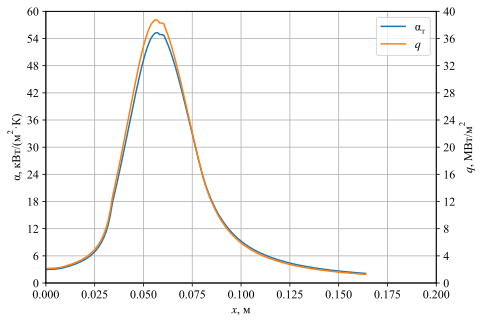

In [322]:
fig = plt.figure(figsize = (7,5), facecolor = 'white')
axm = fig.add_subplot(111)
axv = axm.twinx()

axm.set_xlim(0,0.2)
axm.set_ylim(0,6)
axv.set_ylim(0,3000)

axm.set_xlabel('$\mathit{x}$, м')
axm.set_ylabel('M, $\\lambda$')
axv.set_ylabel('$\mathit{V}$, м/с')

axm.yaxis.set_ticks(np.linspace(0,6, 6))
axv.yaxis.set_ticks(np.linspace(0,3000, 6))

p1, = axm.plot(res['x'],res['M'],label = 'M', c = 'tab:blue')
p2, = axm.plot(res['x'],res['lambda'],label = '$\\lambda$', c = 'tab:orange')
axm.scatter(res['x'][-1],res['lambda'][-1],c = 'tab:orange')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
axm.text(res['x'][-1] - 0.02,res['lambda'][-1] + 0.3,f'{res["lambda"][-1]:.4f}',bbox = props)

p3, = axv.plot(new_res['x'],new_res['V'],label = '$\mathit{V}$', c = 'tab:green')
#p3, = axv.plot(res['x'][:54],res['V'][:54],label = '$\mathit{V}$', c = 'tab:green')
#p3, = axv.plot(res['x'][55:],res['V'][55:],label = '$\mathit{V}$', c = 'tab:green')

lns = [p1, p2, p3]
axm.legend(handles = lns)
axm.grid()
#plt.savefig('M_lambda_V.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize = (7,5), facecolor = 'white')
axp = fig.add_subplot(111)
axr = axp.twinx()

axp.set_xlim(0,0.2) 
axp.set_ylim(0,16)
axr.set_ylim(0,16)

axp.set_xlabel('$\mathit{x}$, м')
axp.set_ylabel('$\mathit{p}$, МПа')
axr.set_ylabel('$\\rho$, кг/$м^3$')

axp.yaxis.set_ticks(np.linspace(0,16, 9))
axr.yaxis.set_ticks(np.linspace(0,16,9))

p1, = axp.plot(res['x'],res['p']/1e6,label = '$\mathit{p}$', c = 'tab:blue')
p2, = axr.plot(res['x'],res['rho_w'],label = '$\\rho$', c = 'tab:orange')

axp.scatter(res['x'][-1],res['p'][-1]/1e6,c = 'tab:blue')
axp.text(res['x'][-1] - 0.02,res['p'][-1]/1e6 + 1,f'{res["p"][-1]/1e6:.5f}',bbox = props)

lns = [p1, p2]
axp.legend(handles = lns)
axp.grid()
#plt.savefig('p_and_rho.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize = (7,5), facecolor = 'white')
plt.plot(res['x'],res['T'],label = '$\mathit{T}$')
plt.plot(res['x'],res['T_r'],label = '$\mathit{T_r}$',c = 'tab:orange')

plt.xlim(0,0.2)
plt.ylim(0,4000)
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{T}$, К')

plt.scatter(res['x'][-1],res['T'][-1],c='tab:blue')
plt.text(res['x'][-1], res['T'][-1] + 300,f'{res["T"][-1]:.1f}',bbox = props)

plt.legend()
plt.grid()
#plt.savefig('T_Tr.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize = (7,5), facecolor = 'white')
axr = fig.add_subplot(111)
axs = axr.twinx()

axr.set_xlim(0,0.2)
axr.set_ylim(0,2)
axs.set_ylim(0,0.02)

axr.set_xlabel('$\mathit{x}$, м')
axr.set_ylabel('Re ⸱ $10^{-6}$')
axs.set_ylabel('St')

axr.yaxis.set_ticks(np.linspace(0,2, 11))
axs.yaxis.set_ticks(np.linspace(0,0.02, 11))

p1, = axr.plot(res['x'],res['Re']/1e6, label = 'Re', c = 'tab:green')
p2, = axs.plot(res['x'],res['St_zv'], label = 'St*', c = 'tab:blue')
p3, = axs.plot(res['x'],res['St'], label = 'St', c = 'tab:orange')

lns = [p1, p2, p3]
axr.legend(handles = lns)
axr.grid()
#plt.savefig('Re_St.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize = (7,5), facecolor = 'white')
axa = fig.add_subplot(111)
axq = axa.twinx()

axa.set_xlim(0,0.2) 
axa.set_ylim(0,15)
axq.set_ylim(0,20)

axa.set_xlabel('$\mathit{x}$, м')
axa.set_ylabel('$\\alpha$, кВт/($м^2$⸱К)')
axq.set_ylabel('$\mathit{q}$, МВт/$м^2$')

axa.yaxis.set_ticks(np.linspace(0,60, 11))
axq.yaxis.set_ticks(np.linspace(0,40, 11))

p1, = axa.plot(res['x'],res['alpha']/1e3,label = '$\\alpha_{т}$', c = 'tab:blue')
p2, = axq.plot(res['x'],res['q']/1e6,label = '$\mathit{q}$', c = 'tab:orange')

lns = [p1, p2]
axa.legend(handles = lns)
axa.grid()
#plt.savefig('alpha_q.png', dpi=300, bbox_inches='tight')
plt.show()

In [318]:
len(new_res['x'])
#new_res['V'][53:56]

149

In [313]:
new_res = {}

In [321]:
new_res['x'] = np.delete(res['x'], [54, 55])
new_res['V'] = np.delete(res['V'], [-2, -1])

In [299]:
px = interp1d(res['x'],res['p'])
Tx = interp1d(res['x'],res['T'])
T_rx = interp1d(res['x'],res['T_r'])
T_wx = interp1d(res['x'],res['T_w'])
C_h2o = interp1d(res['x'],res['C_h2o'])
C_co2 = interp1d(res['x'],res['C_co2'])
C_ch4 = interp1d(res['x'],res['C_ch4'])
M_mu = interp1d(res['x'],res['M_mu'])
q_kx = interp1d(res['x'],res['q'])

p_h2o = lambda x: C_h2o(x) * M_mu(x) * 1e-3 * px(x)
p_co2 = lambda x: C_co2(x) * M_mu(x) * 1e-3 * px(x)
p_ch4 = lambda x: C_ch4(x) * M_mu(x) * 1e-3 * px(x)

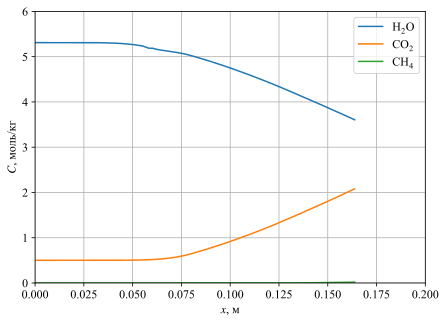

In [300]:
plt.figure(figsize=(7,5),facecolor='white')
plt.plot(res['x'],res['C_h2o'], label = '$H_{2}O$')
plt.plot(res['x'],res['C_co2'], label = '$CO_{2}$',c = 'tab:orange')
plt.plot(res['x'],res['C_ch4'], label = '$CH_{4}$',c = 'tab:green')
plt.ylim(0,6)
plt.xlim(0,0.2)
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{C}$, моль/кг')
plt.legend()
plt.grid()
#plt.savefig('h2o_co2_ch4_c.png', dpi=300, bbox_inches='tight')
plt.show()

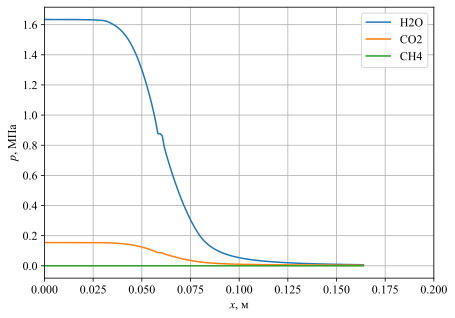

In [301]:
p_h2os = [p_h2o(x)/1e6 for x in res['x']]
p_co2s = [p_co2(x)/1e6 for x in res['x']]
p_ch4s = [p_ch4(x)/1e6 for x in res['x']]

plt.figure(figsize=(7,5),facecolor='white')
plt.plot(res['x'],p_h2os, label = 'H2O')
plt.plot(res['x'],p_co2s, label = 'CO2',c = 'tab:orange')
plt.plot(res['x'],p_ch4s, label = 'CH4',c = 'tab:green')

plt.xlim(0,0.2)
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend()
plt.grid()
#plt.savefig('h2o_co2_ch4_p.png', dpi=300, bbox_inches='tight')
plt.show()

In [302]:
a11, a21, a31 = ttd.get_a('Koef.xlsx')
b1, b2 = ttd.get_b('Koef.xlsx')
c1, c2, c3, c4 = ttd.get_c('Koef.xlsx')

def f_above(f,pl):
    try: f(pl)
    except: res = f(40)
    else: res = f(pl)
    return res

a1 = lambda pl: f_above(a11,pl)
a2 = lambda pl: f_above(a21,pl)
a3 = lambda pl: f_above(a31,pl)

In [303]:
ll = lambda x: 0.9 * np.sqrt(4 * Fss(x) / np.pi)

def eps_co2(x):
    pl = px(x) * 1e-5 * ll(x)
    return 0.025 * 10 ** (a1(pl)* 1e-8*Tx(x)**2 + a2(pl)*1e-5*Tx(x) + a3(pl))

def eps_0h2o(x):
    pl = px(x) * 1e-5 * ll(x)
    return 0.01 * 10 ** (b1(pl)*Tx(x) + b2(pl))

def n(x):
    pl = px(x) * 1e-5 * ll(x)
    n1 = c1(pl)*(np.log10(px(x)*1e-6))**3
    n2 = c2(pl)*(np.log10(px(x)*1e-6))**2
    n3 = c3(pl)*np.log10(px(x)*1e-6)
    return 10 ** (n1 + n2 + n3 + c4(pl))

eps_h2o = lambda x: 1 - (1 - eps_0h2o(x)) ** n(x)
eps_g = lambda x: eps_h2o(x) + eps_co2(x) - eps_h2o(x)*eps_co2(x)

d43 = 10.68 * (D_kr*1e3)**0.293 * (1 - np.exp(-0.1128 * z * 0.3 * p0 * 1e-6))
print(f'd43 = {d43}')
d_l = lambda x: 0.042 * z / rho_kf * (T_rx(x) / (d43 * 1e-6)**2) if z > 0 else 0

eps_ps = lambda x: 1 - (1 - eps_g(x)) * np.exp(-d_l(x) * ll(x))

d43 = 4.776813704182428


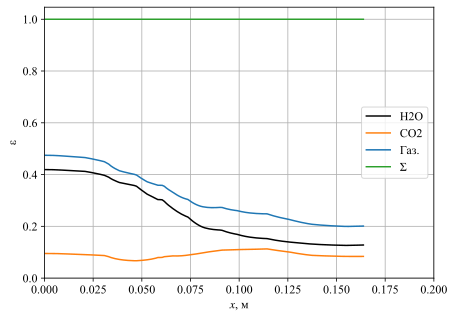

In [304]:
eps_h2os = [eps_h2o(x) for x in res['x']]
eps_co2s = [eps_co2(x) for x in res['x']]
eps_gs = [eps_g(x) for x in res['x']]
eps_pss = [eps_ps(x) for x in res['x']]

plt.figure(figsize=(7,5),facecolor='white')
plt.plot(res['x'], eps_h2os, label = 'H2O', c = 'black')
plt.plot(res['x'],eps_co2s, label = 'CO2',c = 'tab:orange')
plt.plot(res['x'],eps_gs, label = 'Газ.',c = 'tab:blue')
plt.plot(res['x'],eps_pss, label = '$\Sigma$',c = 'tab:green')

plt.xlim(0,0.2)
plt.ylim(0)
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\\varepsilon$')
plt.legend()
plt.grid()
#plt.savefig('epss.png', dpi=300, bbox_inches='tight')
plt.show()

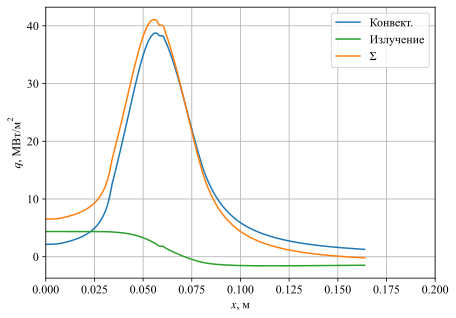

In [305]:
q_l = lambda x: 0.8 * eps_ps(x) * 5.67e-8 * (Tx(x)**4 - T_wx(x)**4)
q_sum = lambda x: q_kx(x) + q_l(x)

q_ls = np.array([q_l(x) for x  in res['x']])
q_sums = np.array([q_sum(x) for x  in res['x']])

plt.figure(figsize=(7,5),facecolor='white')
plt.plot(res['x'],res['q']/1e6,label = 'Конвект.')
plt.plot(res['x'],q_ls/1e6,label = 'Излучение',c = 'tab:green')
plt.plot(res['x'],q_sums/1e6,label = '$\Sigma$',c = 'tab:orange')

plt.xlim(0,0.2)
plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{q}$, МВт/$м^2$')
plt.legend()
plt.grid()
#plt.savefig('q_all.png', dpi=300, bbox_inches='tight')
plt.show()

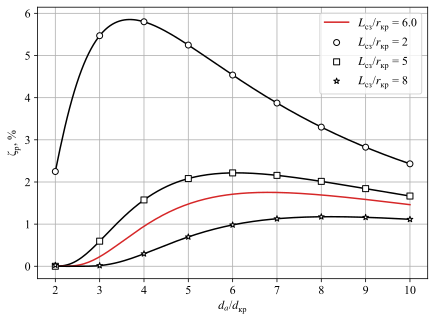

zeta_r = 0.663 %


In [306]:
def zeta_r(ya, L_):
    zeta1 = 13.2 - (8.9 * k(p0,T0) - 9.8) * np.sqrt(ya)
    zeta2 = (0.96 - L_ / (5.88 * ya - 5.44)) ** 6
    zeta3 = (0.37 + 0.114 * ya) ** 2
    return zeta1 * zeta2 / zeta3

L_r_kr = [2,5,La / R_kr, 8]
da_dkr = np.linspace(2,10,150)
da_dkr2 = np.linspace(2,10,9)

lss = ['o','s','-','*']
colors = ['black','black','tab:red','black']
name_label = '$\mathit{L}_{сз}$/$\mathit{r}_{кр}$ = '
plt.figure(figsize=(7,5),facecolor='white')

for i in range(len(lss)):
    zetas = np.array([zeta_r(ya,L_r_kr[i]) for ya in da_dkr])
    zetas2 = np.array([zeta_r(ya,L_r_kr[i]) for ya in da_dkr2])
    if L_r_kr[i] != La / R_kr:
        plt.plot(da_dkr,zetas,color = colors[i], zorder = 2)
        plt.scatter(da_dkr2,zetas2,marker=lss[i], label = name_label + f'{L_r_kr[i]}',edgecolor='black',facecolor='white',zorder = 3)
    else:
        plt.plot(da_dkr,zetas,color = colors[i], label = name_label + f'{L_r_kr[i]}', zorder = 2)

plt.grid(zorder = 1)
plt.legend()
plt.xlabel('$\mathit{d_a} / \mathit{d}_{кр}$')
plt.ylabel('$\zeta_p$, %')
plt.show()

print(f'zeta_r = {zeta_r(D_a / D_kr, La / R_kr):.3f} %')

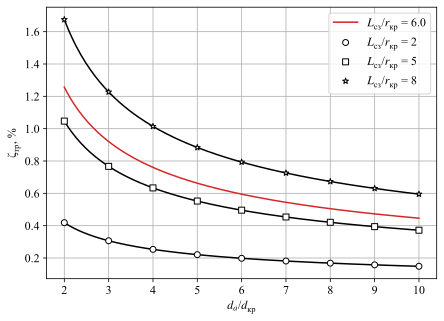

zeta_tr = 0.813 %


In [307]:
def zeta_tr(ya,L_):
    zeta1 = 0.56 * (ya - 1) ** (0.5)
    zeta2 = 2.62 / (k(p0,T0)**2 * 0.6**0.33) - 1
    zeta3 = L_ / (5.88 * ya - 5.44)
    zeta4 = 1 + 16.88 * 0.002**0.4
    return zeta1 * zeta2 * zeta3 * zeta4

plt.figure(figsize=(7,5),facecolor='white')

for i in range(len(lss)):
    zetas = np.array([zeta_tr(ya,L_r_kr[i]) for ya in da_dkr])
    zetas2 = np.array([zeta_tr(ya,L_r_kr[i]) for ya in da_dkr2])
    if L_r_kr[i] != La / R_kr:
        plt.plot(da_dkr,zetas,color = colors[i], zorder = 2)
        plt.scatter(da_dkr2,zetas2,marker=lss[i], label = name_label + f'{L_r_kr[i]}',edgecolor='black',facecolor='white',zorder = 3)
    else:
        plt.plot(da_dkr,zetas,color = colors[i], label = name_label + f'{L_r_kr[i]}', zorder = 2)

plt.grid(zorder = 1)
plt.legend()
plt.xlabel('$\mathit{d_a} / \mathit{d}_{кр}$')
plt.ylabel('$\zeta_{тр}$, %')
plt.show()

print(f'zeta_tr = {zeta_tr(D_a / D_kr, La / R_kr):.3f} %')

In [308]:
# Потери на неравновесность k-f
L_ = La / R_kr
y_a = D_a / D_kr
L_p = 5.88*y_a - 5.44
L_0 = L_ / L_p
dzeta_0 = 14.4 * (D_kr*1e3)**(-0.33)
if 0 < z < 0.5: 
    k_0 = (z / 0.3)**2
else:
    k_0 = 1
if 2 < p0 < 8: 
    k_1 = 1.047 - 0.0013*p_0*10
else:
    k_1 = 1
if 0.3 < L_0 < 0.5: 
    k_2 = 1.3 - 0.462 * L_0
else:
    k_2 = 1
if 3 < y_a < 6: 
    k_3 = 1.112 - 0.037*y_a
else:
    k_3 = 1
if 3 < d43 < 7: 
    k_4 = 1.162 - 0.168*d43
else:
    k_4 = 1
dzeta_dv = dzeta_0*k_0*k_1*k_2*k_3*k_4
dzeta_dv

2.6813681718709126

In [309]:
L_p

15.77649484536082

In [310]:
zeta_tepl = 0.5
zeta_kr = z * 390e3 * (1 - res['T'][-1] / 2300) / res['V'][-1]**2 * 100
print(f'zeta_kr = {zeta_kr:.3f} %')

zeta_sum = zeta_tr(D_a / D_kr, La / R_kr) + zeta_r(D_a / D_kr, La / R_kr) + zeta_kr + zeta_tepl + dzeta_dv
print(f'zeta_sum = {zeta_sum:.3f} %\n',
      f'I_ud = {I_ud*(1 - zeta_sum*1e-2):.0f}\n',
      f'I_sum = {I_sum*(1 - zeta_sum*1e-2):.0f} vs', I_sum)

zeta_kr = 0.884 %
zeta_sum = 5.541 %
 I_ud = 2802
 I_sum = 68952 vs 72997


In [311]:
res['V'][-1]

2922.0958040606083